# Introduction: Predicting pump failures with a MLP

Notebook by Jürgen Brauer, [www.juergenbrauer.org](http://www.juergenbrauer.org)

In this notebook we will show that we can learn a MLP for predicting whether a water pump will fail in a future time window or not. The prediction / pump failure classification rate is about 97% for the following settings.

The input for the MLP is a time window of some specified length of the pump sensor data (52 sensors, called "sensor_00" till "sensor_51").

The output of the MLP is a single output neuron:
- 0 means: there will be no failure (machine status "NORMAL")
- 1 means: there will be a pump failure (machine status "BROKEN"/"RECOVERING").

The following settings are used:

In [ ]:
nr_examples_to_prepare = 2000
window_width_input_minutes = 60
window_width_output_minutes = 60*24

The MLP will be trained e.g. on 2000/2=1000 training samples, where the input window covers 60 minutes (1 hour of sensor data).

The MLP input vector x length will be accordingly 60 minutes x 52 sensor samples/minute = a 3120-dimensional input vector.

The MLP output vector y length is 1 (just one output neuron).
For checking whether there was a pump failure after the input window (so for generating the teacher vectors y), we check in some time window of length 60 x 24 (i.e. 1 day = 60 minutes * 24 hours), whether the machine went into state "BROKEN" or "RECOVERING".

1000 randomly extracted samples (x,y) will be used for training.

1000 randomly extracted samples (x,y) will be used for testing.

For generating one of these 2000 training samples we
- randomly choose a sample minute
- compute the input vector x from the input window starting at this minute
- compute the output vector y by checking whether in the following time window the pump failed
- combine both the input and output vector into one training sample (x,y)

# Sketch of the approach

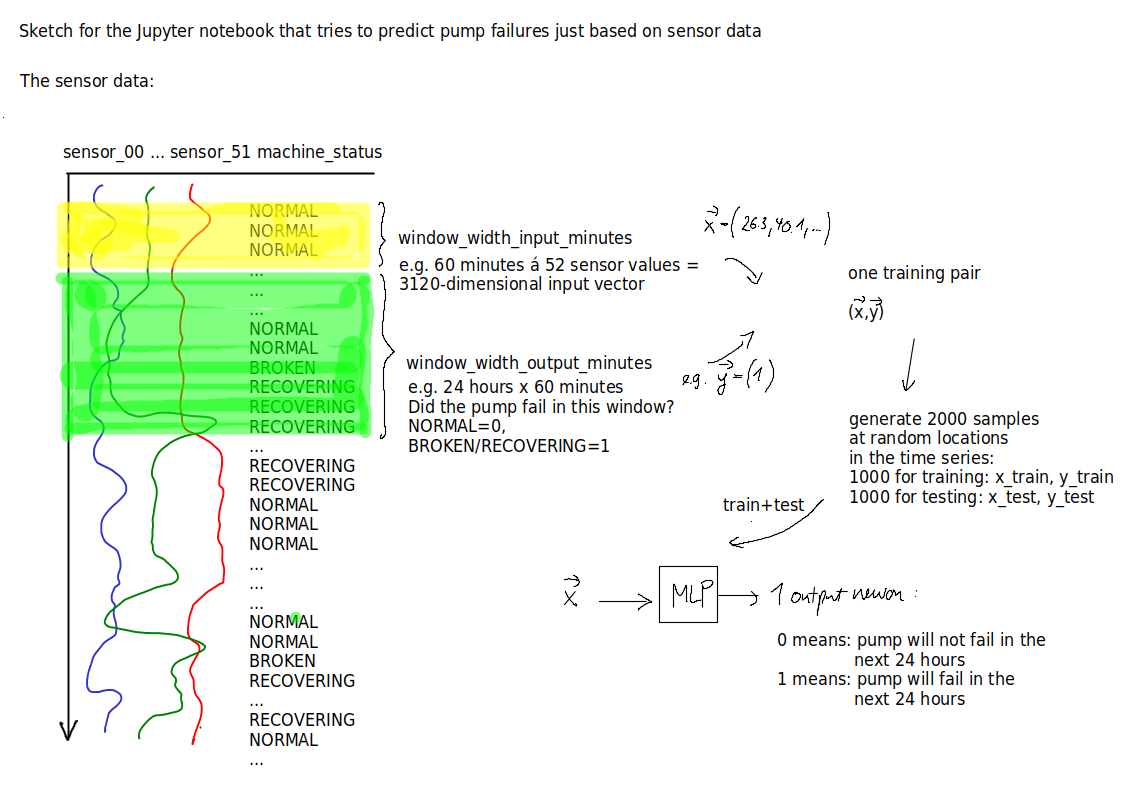

# Read in the sensor and machine status data

In [ ]:
import pandas
print("Your Pandas version is ", pandas.__version__)
fname = "/kaggle/input/pump-sensor-data/sensor.csv"
df = pandas.read_csv( fname )

In [ ]:
type(df)

In [ ]:
# The first column has no name. Give it a name!
df.rename(columns={ df.columns[0]: "Samplenr" }, inplace = True)

In [ ]:
df[:5]

# Show some of the rows from the .csv file

In [ ]:
df.head(7)

In [ ]:
df.tail(3)

In [ ]:
df.dtypes

In [ ]:
df.describe()

# Which different machine states are there and how often?

In [ ]:
possible_machine_states = list(df.machine_status.unique())

In [ ]:
possible_machine_states

In [ ]:
# Get all rows where machine status was "NORMAL"
df_status_NORMAL = df[ df["machine_status"] == "NORMAL" ]

In [ ]:
type(df_status_NORMAL)

In [ ]:
df_status_NORMAL.shape

In [ ]:
nr_rows_machine_status_NORMAL = df_status_NORMAL.shape[0]

In [ ]:
nr_rows_machine_status_NORMAL

In [ ]:
nr_rows_total = df.shape[0]

In [ ]:
nr_rows_total

In [ ]:
percent_machine_status_NORMAL = \
    (nr_rows_machine_status_NORMAL / nr_rows_total) * 100.0

In [ ]:
percent_machine_status_NORMAL

In [ ]:
df_status_BROKEN = df[ df["machine_status"] == "BROKEN" ]

In [ ]:
df_status_BROKEN

In [ ]:
nr_rows_machine_status_BROKEN = df_status_BROKEN.shape[0]

In [ ]:
print("So {0} times, the pump was broken".format(nr_rows_machine_status_BROKEN))

In [ ]:
df_status_RECOVERING = df[ df["machine_status"] == "RECOVERING" ]
nr_rows_machine_status_RECOVERING = df_status_RECOVERING.shape[0]

In [ ]:
percent_machine_status_RECOVERING = \
    (nr_rows_machine_status_RECOVERING / nr_rows_total) * 100.0

In [ ]:
percent_machine_status_RECOVERING

In [ ]:
import matplotlib.pyplot as plt

xpos = [1,2,3]
data = [nr_rows_machine_status_NORMAL,
        nr_rows_machine_status_BROKEN,
        nr_rows_machine_status_RECOVERING]

fig, ax = plt.subplots()
ax.bar(xpos,data)
ax.set_xticks(xpos)
ax.set_xticklabels(possible_machine_states)
ax.set_title("How often was the machine (pump) in each machine state?")
plt.show()

# How long did the 7 RECOVERING phases need?

In [ ]:
df_status_BROKEN

In [ ]:
row_numbers_machine_BROKEN = list(df_status_BROKEN["Samplenr"].values)

In [ ]:
row_numbers_machine_BROKEN

In [ ]:
recovering_times_hours = []

for i in row_numbers_machine_BROKEN:
    print("\nMachine in status BROKEN in row: {0}".format(i) )
    
    go_further = True
    j = i
    while go_further:
        j += 1
        machine_status_in_row_j = df.iloc[j]["machine_status"]        
        if machine_status_in_row_j != "RECOVERING":
            go_further = False
            
    print("Machine went back to status {0} in row: {1}"
          .format(machine_status_in_row_j, j-i)
          )
    recovering_hours = (j-i)/60
    recovering_days  = recovering_hours / 24
    print("Machine was in RECOVERING state for {0:.1f} hours / {1:.1f} days"
          .format( recovering_hours, recovering_days )
         )
    
    recovering_times_hours.append(recovering_hours)

In [ ]:
recovering_times_hours

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xpos = np.arange( len(recovering_times_hours) )

fig, ax = plt.subplots()
ax.bar(xpos,recovering_times_hours)
ax.set_xticks(xpos)
ax.set_xticklabels(xpos)
ax.set_title("Duration of RECOVERING phase [in hours] for each of the 7 pump failures")
plt.show()

In [ ]:
min(recovering_times_hours)

In [ ]:
max(recovering_times_hours)

# Visualize some of the sensor data

In [ ]:
df["sensor_17"]

In [ ]:
type( df["sensor_17"] )

In [ ]:
sensor_values = list( df["sensor_17"] )

In [ ]:
type(sensor_values)

In [ ]:
len(sensor_values)

In [ ]:
sensor_values[:10]

In [ ]:
import matplotlib.pyplot as plt

some_few_values = sensor_values[:100]
min_val = min(some_few_values)
max_val = max(some_few_values)

plt.plot( some_few_values, color="green", linestyle="-",
          marker=".", linewidth=0.5 )
plt.hlines(min_val, 0,100, color="blue")
plt.hlines(max_val, 0,100, color="red")
plt.xlabel("Minute", fontsize=10)
plt.ylabel("Sensor value", fontsize=10)
plt.title("The first 100 sensor values of Sensor 17", fontsize=14)
plt.grid()
#plt.savefig("sensor_17.png")
plt.show()

# Fill data gaps (NaN values)

How many missing values are there in total?

In [ ]:
df.isna().sum().sum()

In [ ]:
df.isna().sum()

In [ ]:
only_numerical_cols = df.iloc[:,2:54]

In [ ]:
only_numerical_cols

In [ ]:
df.describe()

In [ ]:
fill_value = -1.0
data_with_gaps_filled = df.fillna( fill_value )

In [ ]:
data_with_gaps_filled.isna().sum()

# Prepare data for training and testing

## How to get an example input window

In [ ]:
sensordata_cols_only = data_with_gaps_filled.iloc[:,2:54]

In [ ]:
sensordata_cols_only

Scale data column-wise to feature range [0,1]. If all inputs are in the same range, it makes it easier for a MLP to learn.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler with feature range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_sensor_data = scaler.fit_transform(sensordata_cols_only)

In [ ]:
scaled_sensor_data

In [ ]:
window_width_input_minutes = 60
window_width_output_minutes = 60*24

In [ ]:
start_minute = 0
a_single_input_window = scaled_sensor_data[start_minute:start_minute+window_width_input_minutes]

In [ ]:
type(a_single_input_window)

In [ ]:
# <a_single_input_window> contains the data for 60 minutes
# for each of the 52 sensors
a_single_input_window.shape

In [ ]:
# Map window to a vector, since we need a 1D input for the MLP
a_single_input_vector = a_single_input_window.flatten()

In [ ]:
a_single_input_vector.shape

## How to check whether the pump failed in some time window after the input window

In [ ]:
def check_for_pump_failure(start, stop):
    """
    Returns 1, if the pump failed in time window
    (start,stop)
    
    Returns 0, else.
    """
    for minute in range(start,stop):
        # get the corresponding row from the data
        machine_state_in_this_minute = df["machine_status"].iloc[minute]
        if machine_state_in_this_minute in ["BROKEN", "RECOVERING"]:
            return 1
    
    return 0

In [ ]:
row_numbers_machine_BROKEN

In [ ]:
check_for_pump_failure(0,17000)

In [ ]:
check_for_pump_failure(17000,17200)

In [ ]:
check_for_pump_failure(20000,30000)

In [ ]:
check_for_pump_failure(65000,69318)

In [ ]:
check_for_pump_failure(65000,69319)

## Prepare example data

In [ ]:
# Max row nr such that input window and output window
# still fit into the time series data?
max_row_nr = nr_rows_total-window_width_input_minutes-window_width_output_minutes

# collect the desired number of (input_vec,output_vec) examples
training_pairs = []
for example_nr in range(0,nr_examples_to_prepare):
    
    # show progress
    if example_nr % 100 == 0:
        print("Collected examples so far:", example_nr)
    
    # 1. guess a random minute
    found_example_where_pump_worked_in_input_window = False
    while not found_example_where_pump_worked_in_input_window:
    
        rnd_minute = np.random.randint(0,max_row_nr)
        
        # Make sure, the input window does not cover
        # already a phase where the machine is broken:
        # We want examples where the input window covers
        # a normal state and we want to predict whether
        # the pump will fail or not in the next time window
        # We do NOT want to collect examples where the machine is
        # already BROKEN in the input window
        # (could be too easy to predict whether the machine
        #  will be broken in the future as well)
        start = rnd_minute
        stop  = start+window_width_input_minutes
        if check_for_pump_failure(start,stop)==0:
            found_example_where_pump_worked_in_input_window = True
            
    
    # 2. get the input vector from the 2D sensor matrix data
    a_single_input_window = scaled_sensor_data[rnd_minute:rnd_minute+window_width_input_minutes]
    a_single_input_vector = a_single_input_window.flatten()
    
    # 3. check whether in time range
    #    (rnd_minute+window_width_input_minutes,
    #     rnd_minute+window_width_input_minutes+window_width_output_minutes)
    #    the pump failed
    start = rnd_minute+window_width_input_minutes
    stop  = rnd_minute+window_width_input_minutes+window_width_output_minutes
    output_value = check_for_pump_failure(start,stop)
    
    # 4. add a new training pair to list of training pairs
    training_pairs.append( (a_single_input_vector, output_value) )
    
    

In [ ]:
len(training_pairs)

## Prepare a large example data matrix D from the list of training pairs

In [ ]:
input_vec_len = training_pairs[0][0].shape[0]
output_vec_len = 1


D = np.zeros( (nr_examples_to_prepare, input_vec_len+output_vec_len))
print("Shape of D is", D.shape)

# Fill data matrix D with input vec + output vec in each row
for nr in range(0,nr_examples_to_prepare):
    (x,y) = training_pairs[nr]
    D[nr,0:input_vec_len] = x
    D[nr,input_vec_len]   = y

## From example data matrix get train and test matrices

In [ ]:
nr_train_samples = int(nr_examples_to_prepare/2)
x_train = D[0:nr_train_samples, 0:input_vec_len]
y_train = D[0:nr_train_samples, input_vec_len]

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_test = D[nr_train_samples:, 0:input_vec_len]
y_test = D[nr_train_samples:, input_vec_len]

In [ ]:
x_test.shape

In [ ]:
y_test.shape

# Build MLP and train it

In [ ]:
import tensorflow
tensorflow.__version__

Jetzt bauen wir das MLP mit Keras zusammen!

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Dense(200, activation='relu', input_shape=(input_vec_len,)) )
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.build()

In [ ]:
model.summary()

Jetzt trainieren wir das Modell!

In [ ]:
history = model.fit(x_train, y_train, epochs=3000)

In [ ]:
type(history)

In [ ]:
type(history.history)

In [ ]:
history.history["loss"][:20]

In [ ]:
plt.plot(history.history["loss"])
plt.show()

# Test the final MLP

In [ ]:
preds = model.predict(x_test)

In [ ]:
preds.shape

In [ ]:
y_test.shape

In [ ]:
preds = preds.flatten()

In [ ]:
preds.shape

In [ ]:
preds[:20]

In [ ]:
min(preds)

In [ ]:
max(preds)

In [ ]:
pump_failure_in_future_window = 0
correctly_predicted_pump_failures = 0
correctly_predicted = 0
nr_test_samples = preds.shape[0]

tp = 0
tn = 0
fp = 0
fn = 0

for test_nr in range(0,nr_test_samples):
    ground_truth_output = y_test[test_nr]
    if preds[test_nr] < 0.5:
        predicted_output = 0.0
    else:
        predicted_output = 1.0
    print("Test example #{0}: ground truth vs. predicted machine status: {1} vs. {2}"
          .format(test_nr, ground_truth_output, predicted_output ))
    
    if predicted_output == ground_truth_output:
        correctly_predicted +=1
        
    if ground_truth_output==1:
        pump_failure_in_future_window += 1
        if predicted_output == ground_truth_output:
            correctly_predicted_pump_failures +=1
            
    if ground_truth_output==1:
        if predicted_output == ground_truth_output:
            # True positive:
            # There was a pump failure
            # and the MLP predictor predicted it
            tp+=1
        else:
            # False negative:
            # There was a pump failure
            # BUT the MLP predictor predicted it not
            fn+=1
            
    if ground_truth_output==0:        
        if predicted_output == ground_truth_output:
            # True negative:
            # There was no pump failure
            # and the MLP predictor predicted no pump failure
            tn+=1
        else:
            # False positive:
            # There was no pump failure
            # BUT the MLP predictor predicted a pump failure
            fp+=1
            
        
correct_classification_percent = (correctly_predicted/nr_test_samples)*100.0
print("\nCorrectly predicted {0} of {1} test examples --> {2}%"
      .format(correctly_predicted, nr_test_samples, correct_classification_percent))

print("\nIf there was really a pump failure in the future window,\n"
      "the MLP could predict it in {0} of the {1} pump failure (in future window) example cases."
      .format(correctly_predicted_pump_failures, pump_failure_in_future_window))

print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {0:.2f}".format(precision))
print("Recall   : {0:.2f}".format(recall))

# Conclusion

In [ ]:
print("The machine status can be predicted with an accuracy of {0}%".format(correct_classification_percent)) 